In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

all_data = pd.concat((train_data, test_data), axis=0)

y = train_data['price']

train_data.head(2)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20140915T000000,392000.0,4,3.75,2220,3797,1.5,0,0,4,6,1330,890,1917,0,98108,47.5574,-122.315,1490,4340
1,20140730T000000,300000.0,3,2.25,1960,1585,2.0,0,0,3,7,1750,210,2003,0,98118,47.5414,-122.288,1760,1958


Разобьем работу на 4 этапа:
1. Исследование данных
2. Предварительная обработка данных
3. Построение модели
4. Представление результатов

# 1 этап - исследование данных

In [3]:
train_data.info()
print()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17290 entries, 0 to 17289
Data columns (total 20 columns):
date             17290 non-null object
price            17290 non-null float64
bedrooms         17290 non-null int64
bathrooms        17290 non-null float64
sqft_living      17290 non-null int64
sqft_lot         17290 non-null int64
floors           17290 non-null float64
waterfront       17290 non-null int64
view             17290 non-null int64
condition        17290 non-null int64
grade            17290 non-null int64
sqft_above       17290 non-null int64
sqft_basement    17290 non-null int64
yr_built         17290 non-null int64
yr_renovated     17290 non-null int64
zipcode          17290 non-null int64
lat              17290 non-null float64
long             17290 non-null float64
sqft_living15    17290 non-null int64
sqft_lot15       17290 non-null int64
dtypes: float64(5), int64(14), object(1)
memory usage: 2.6+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 e

Благодаря этой информации мы видим,что в data set нет отсутствующих значений.

In [4]:
train_data['sqft_living'].describe()

count    17290.000000
mean      2073.323135
std        915.867612
min        290.000000
25%       1420.000000
50%       1910.000000
75%       2540.000000
max      13540.000000
Name: sqft_living, dtype: float64

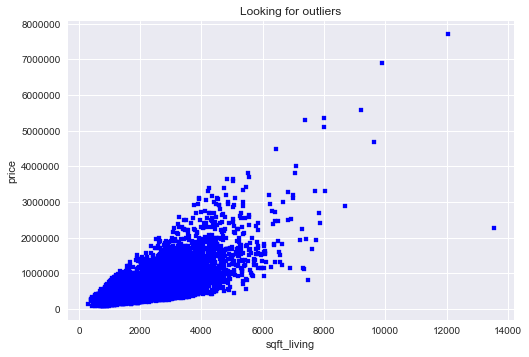

In [5]:
plt.scatter(train_data.sqft_living, train_data.price, c = "blue", marker = "s", s = 10)
plt.title("Looking for outliers")
plt.xlabel("sqft_living")
plt.ylabel("price")
plt.show()

Видим,что присутствуют выбросы.То есть очень большой дом был продан за низкую цену.

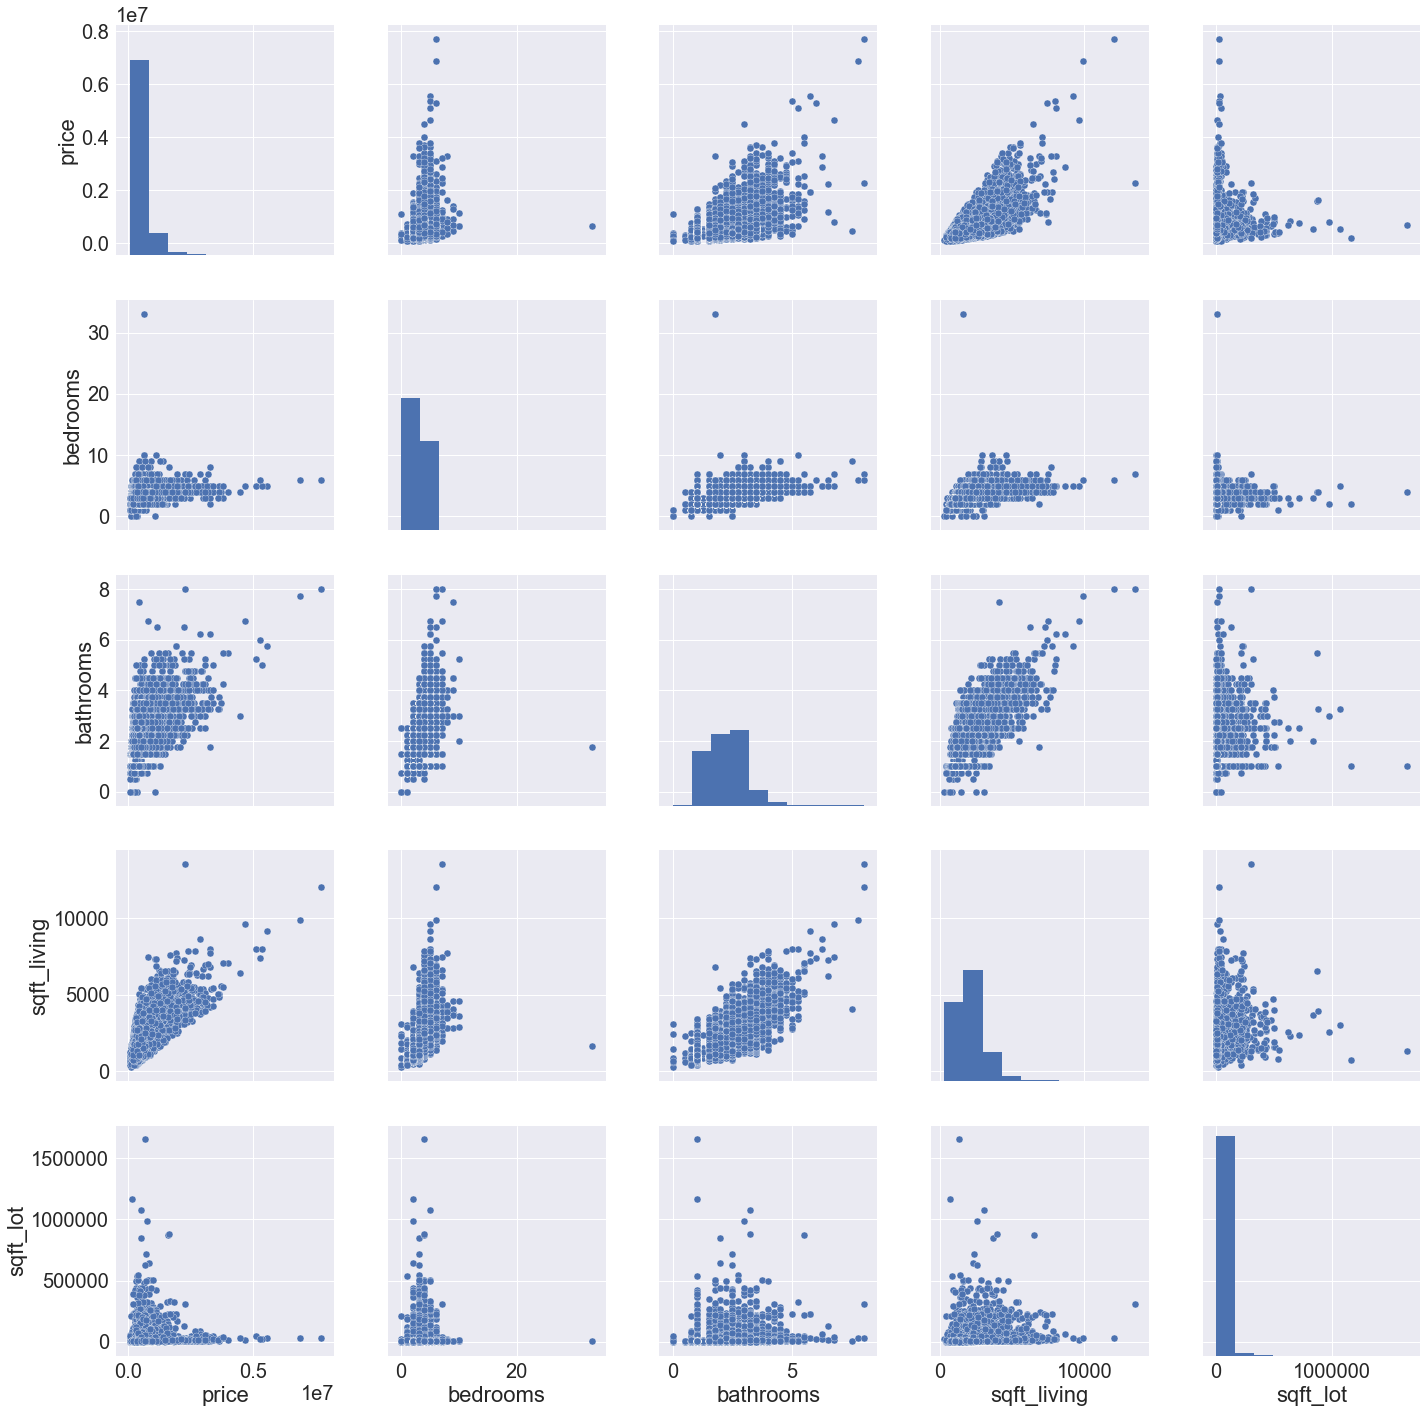

In [6]:
sns.set(font_scale = 2)
cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']
sns.pairplot(train_data[cols], size = 4)
plt.show()

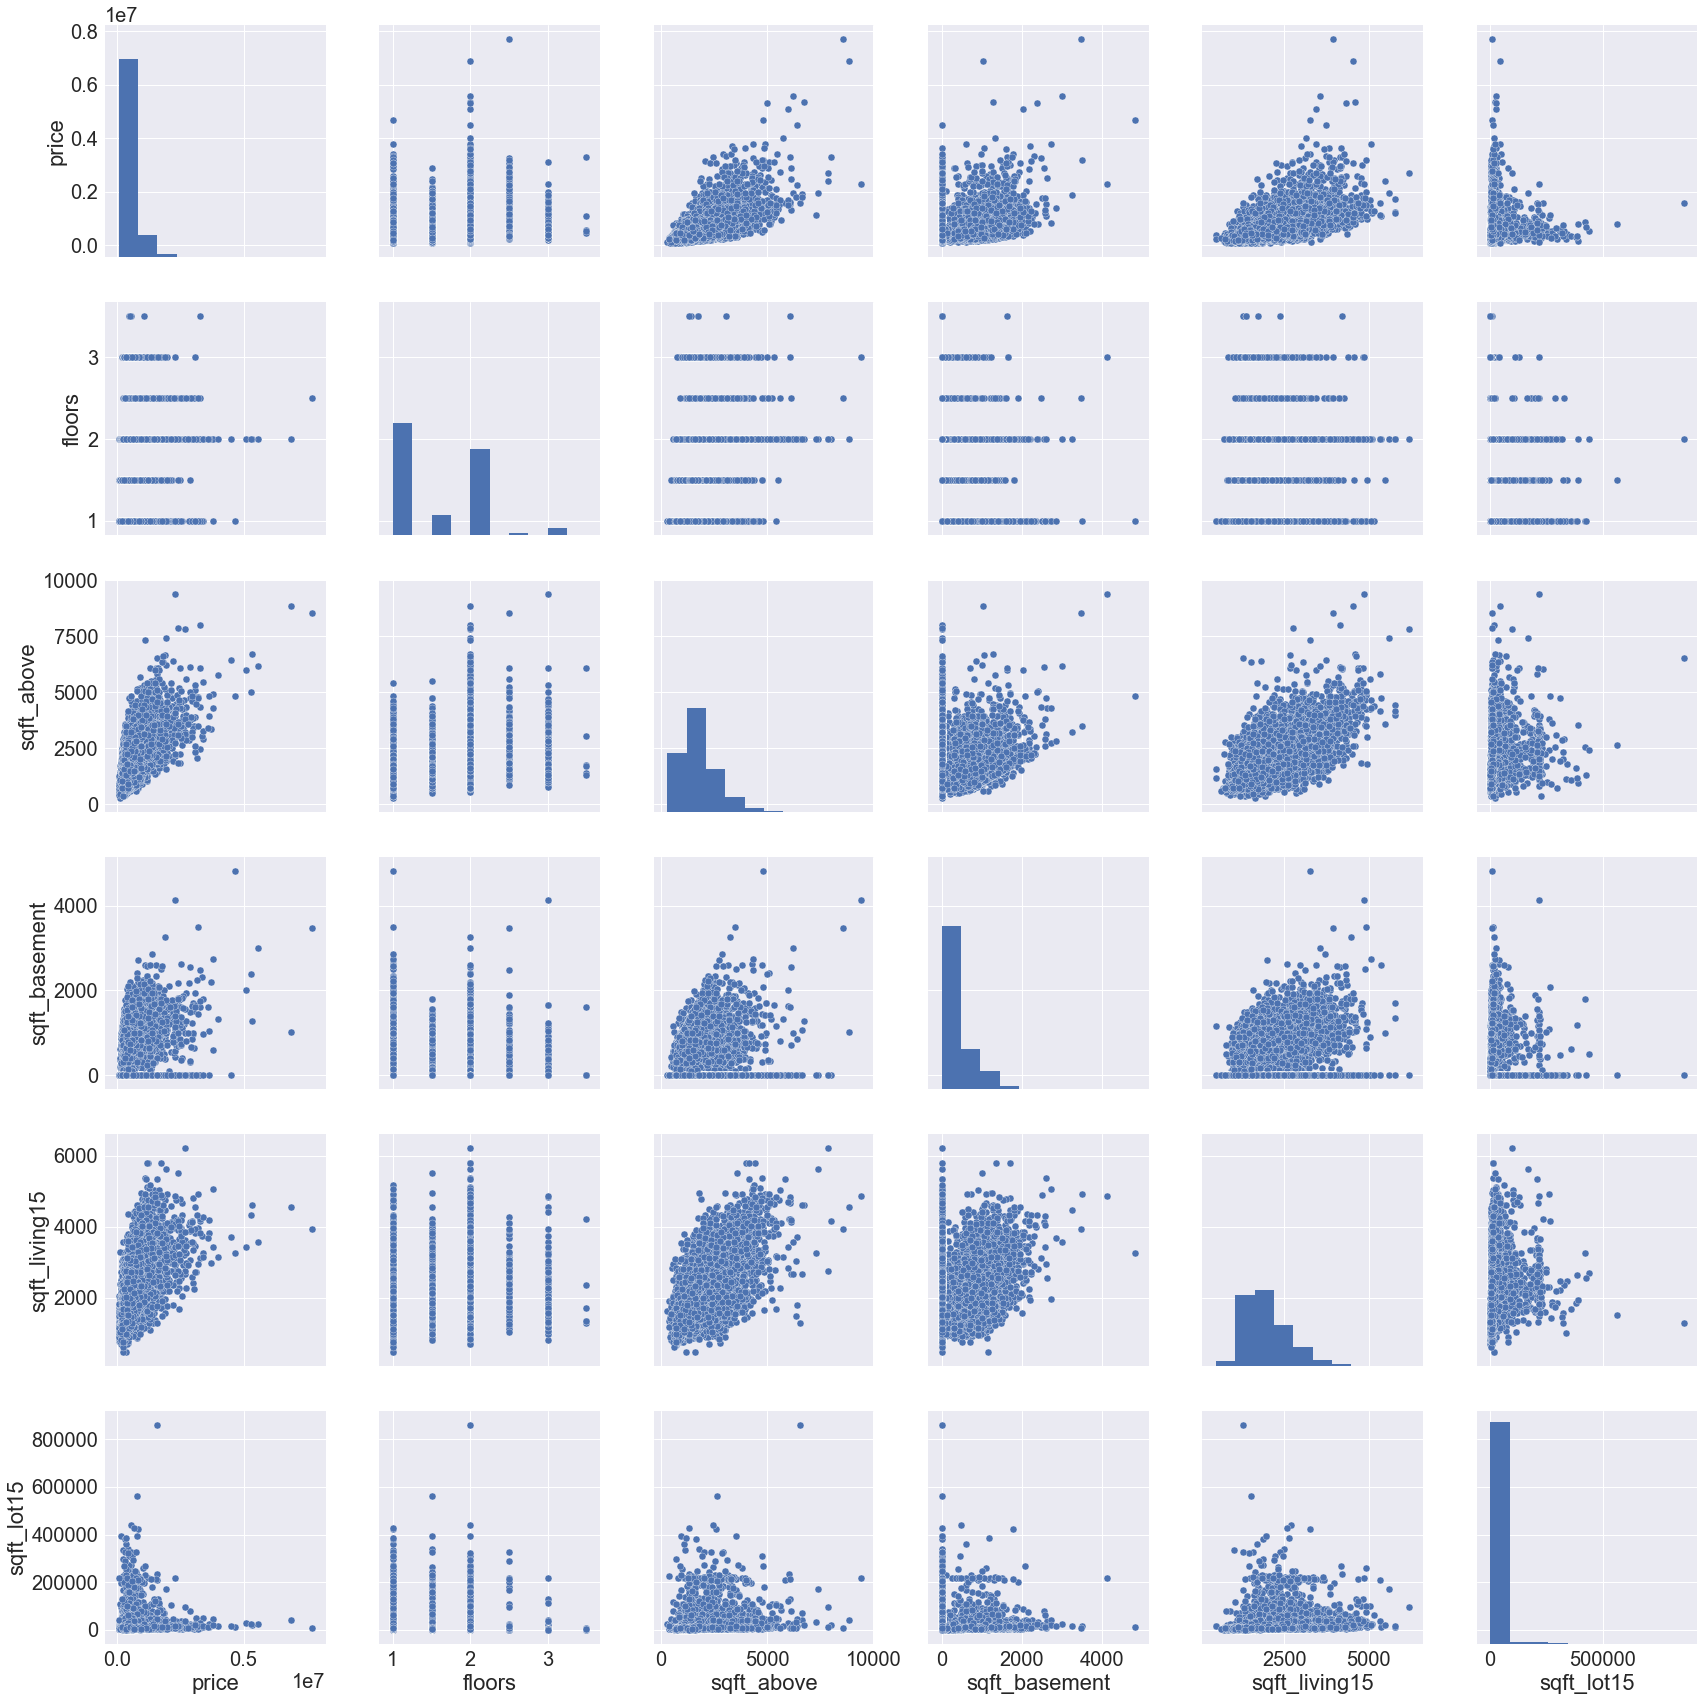

In [7]:
sns.set(font_scale = 2)
cols = ['price', 'floors', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
sns.pairplot(train_data[cols], size = 4)
plt.show()

На данных графиках смотрим на диагональ.По графикам видно,что гистограммы имеют смещение,то есть не имеют нормальное распределения.Следовательно модели регрессии могут работать не очень хорошо,поскольку они предполагают нормальное распределение данных.

На работу деревьев такое смещение не влияет.

Можно наглядно увидить некоторые зависимости,если посмотреть на первую строчку обоих графиков.Большая часть из них линейна с ценой дома.Выделяются зависимости между количеством этажей в доме и ценой дома,количеством спален и ценой дома.Здесь не получается обнаружить какого-то паттерна.


In [8]:
print("Ищем наиболее важные характеристики")
cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
corr = train_data[cols].corr()
corr.sort_values(["price"], ascending = False, inplace = True)
print(corr.price)

Ищем наиболее важные характеристики
price            1.000000
sqft_living      0.701614
sqft_above       0.603491
sqft_living15    0.585906
bathrooms        0.523708
sqft_basement    0.327017
bedrooms         0.312017
floors           0.256334
sqft_lot         0.086331
sqft_lot15       0.080190
Name: price, dtype: float64


Как и ожидалось,меньше всего коррелированы характеристики - sqft_lot и sqft_lot15 из-за наличия большого количества нулей.А также floors и bedrooms.

# 2 этап - предварительная обработка данных
1. Разделим характеристики на категориальные и количественные
2. Для категориальных переменных создадим dummy variables - фиктивные переменные

In [9]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

all_data = pd.concat((train_data, test_data), axis=0)
y = train_data['price']

all_data['yr_built'] = all_data['yr_built'].astype(object)
all_data['yr_renovated'] = all_data['yr_renovated'].astype(object)
all_data['lat'] = all_data['lat'].astype(object)
all_data['long'] = all_data['long'].astype(object)
all_data['zipcode'] = all_data['zipcode'].astype(object)
all_data['waterfront'] = all_data['waterfront'].astype(object)
all_data['view'] = all_data['view'].astype(object)
all_data['condition'] = all_data['condition'].astype(object)
all_data['grade'] = all_data['grade'].astype(object)

categorical_features = all_data.select_dtypes(include = ["object"]).columns
categorical_features = categorical_features.drop('lat')
categorical_features = categorical_features.drop('long')
categorical_features = categorical_features.drop('date')

numerical_features = all_data.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop('price')

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

all_data_num = all_data[numerical_features]
all_data_cat = all_data[categorical_features]

all_data_cat = pd.get_dummies(all_data_cat)

Numerical features : 9
Categorical features : 7


Уберем такие характеристики как широта,долгота и дата,чтобы излишне не усложнять модель - при создании фиктивных переменных для них количество характеристик возрастает до 600,что негативно отражается на времени работы алгоритмов.При этом широту и долготу заменяет характеристика индекс,выступая как бы в роли кластеров,в котором содержатся близко расположенные координаты. 
Если примерно посмотреть как расположены координаты до становится ясно,что это Сиэттл и его пригороды.Рассмотрим как выглядит карта с индексами для данного города.
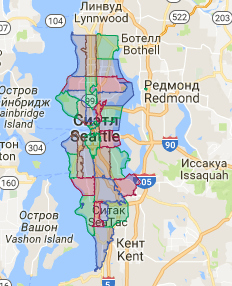
Таким образом,индексы разбивают весь город на районы или кластеры,эту характеристику и будем использовать.

Поскольку sklearn изначально не может работать с категориальными характеристиками,используем one-hot encoding для создания dummy variables.

In [10]:
all_data = pd.concat([all_data_num, all_data_cat], axis = 1)

train_data = all_data[0:train_data.shape[0]] 
test_data = all_data[train_data.shape[0]:all_data.shape[0]] 

y_scaler = MinMaxScaler()
all_data['sqft_living'] = y_scaler.fit_transform(all_data['sqft_living'])
all_data['sqft_living15'] = y_scaler.fit_transform(all_data['sqft_living15'])
all_data['sqft_basement'] = y_scaler.fit_transform(all_data['sqft_basement'])
all_data['bedrooms'] = y_scaler.fit_transform(all_data['bedrooms'])

y_scaler = StandardScaler()
all_data['sqft_living'] = y_scaler.fit_transform(all_data['sqft_living'])
all_data['sqft_living15'] = y_scaler.fit_transform(all_data['sqft_living15'])
all_data['sqft_basement'] = y_scaler.fit_transform(all_data['sqft_basement'])
all_data['bedrooms'] = y_scaler.fit_transform(all_data['bedrooms'])

Используем StandardScaler и MinMaxScaler для лучшей работы алгоритмов линейной регрессии и K-Neighbors.

# 3 этап - построение модели

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

train_set_lr = []
train_set_dt = []
train_set_kn = []

test_set_lr = []
test_set_rf = []
test_set_dt = []
test_set_kn = []

train_set_rf_oob = []

test_set_rf_oob = []

for i in range(5):
        models = [LinearRegression(n_jobs = -1),
                  RandomForestRegressor(n_jobs = -1,oob_score = True),
                  DecisionTreeRegressor(),
                  KNeighborsRegressor()
                 ]
 
        for model in models:
            kf = KFold(10,True)
    
            for train_index, test_index in kf.split(train_data):
                X_train, X_test = train_data.iloc[train_index], train_data.iloc[test_index]
                y_train, y_test = y[train_index], y[test_index]
                    
            m = str(model)
            Model_name = m[:m.index('(')]
            model.fit(X_train, y_train)
            
            y_test_pred = model.predict(X_test)
            y_train_pred = model.predict(X_train)
            
            if Model_name == "LinearRegression":
                train_set_lr.append(np.sqrt(mse(y_train,y_train_pred)))
                test_set_lr.append(np.sqrt(mse(y_test,y_test_pred)))
            if Model_name == "RandomForestRegressor":
                train_set_rf_oob.append(model.score(X_train,y_train))
                test_set_rf_oob.append(model.oob_score_)
                test_set_rf.append(np.sqrt(mse(y_test,y_test_pred)))
            if Model_name == "DecisionTreeRegressor":
                train_set_dt.append(np.sqrt(mse(y_train,y_train_pred)))
                test_set_dt.append(np.sqrt(mse(y_test,y_test_pred)))
            if Model_name == "KNeighborsRegressor":
                train_set_kn.append(np.sqrt(mse(y_train,y_train_pred)))
                test_set_kn.append(np.sqrt(mse(y_test,y_test_pred)))
    

print("Test set RMSE error for LinearRegression",np.mean(test_set_lr))
print("Test set RMSE error for RandomForest",np.mean(test_set_rf))
print("Test set RMSE error for DecisionTree",np.mean(test_set_dt))
print("Test set RMSE error for KNeighbors",np.mean(test_set_kn))

print()

print("Training set RMSE error for LinearRegression",np.mean(train_set_lr))
print("Training set RMSE error for DecisionTree",np.mean(train_set_dt))
print("Training set RMSE error for KNeighbors",np.mean(train_set_kn))

print()

print("Training set oob error for RandomForest",np.mean(train_set_rf_oob))
print("Test set oob error for RandomForest",np.mean(test_set_rf_oob))

Test set RMSE error for LinearRegression 150073.498887
Test set RMSE error for RandomForest 174936.708435
Test set RMSE error for DecisionTree 210100.647188
Test set RMSE error for KNeighbors 268938.555105

Training set RMSE error for LinearRegression 140831.17983
Training set RMSE error for DecisionTree 10130.5310622
Training set RMSE error for KNeighbors 209337.832964

Training set oob error for RandomForest 0.964862744837
Test set oob error for RandomForest 0.728555219433


Исследуем 4 алгоритма - линейную регрессию,Random Forest,дерево решений,метод k-ближайших соседей.Метрика - root mean square error - RMSE.

Для того,чтобы избежать переобучения используем стратегию кросс-валидации K-Fold.

Как видим наилучшие результаты на test set показала линейная регрессия.Но у нее случаются большие скачки ошибки.По причине больших скачков не будем использовать данный алгоритм.RandomForest тоже показал хороший результат,но сильно переобучился,поэтому попробуем изменить параметры алгоритма.Алгоритм DecisionTree показал еще большее переобучение,а поскольку RandomForest является версией DecisionTree,которая позволяет уменьшить переобучение,то его рассматривать не будем.Метод k-ближайших соседей тоже рассматривать не будем как показавший наихудший результат на обеих выборках.

In [14]:
#Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features':['auto','sqrt'],'min_samples_leaf':[1,3,6],'n_estimators':[10,70,80],'oob_score':[True]}
rfc = RandomForestRegressor(n_jobs=-1)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1)

kf = KFold(10,True)
    
for train_index, test_index in kf.split(train_data):
    X_train, X_test = train_data.iloc[train_index], train_data.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
                
gcv.fit(X_train, y_train)
y_test_pred = gcv.predict(X_test)
print("Best params ",gcv.best_params_)

print("Rmse ",np.sqrt(mse(y_test,y_test_pred)))

Best params  {'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 80, 'oob_score': True}
Rmse  145418.8704


Для того,чтобы уменьшить эффект переобучения,попробуем с помощью перебора подобрать параметры RandomForest.А именно,варьируем число характеристик,то есть уменьшаем сложность модели,а также меняем другие параметры - число деревьев,минимальное число объектов при котором узел считается терминальным.

# 4 этап - представление результатов

In [15]:
model = RandomForestRegressor(n_jobs = -1,max_features = 'auto', min_samples_leaf = 1, n_estimators = 80, oob_score = True)

model.fit(train_data, y)
pred = model.predict(test_data)

np.savetxt('pred.csv',pred,fmt='%f')